In [106]:
import os
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
fo = 2.5e6

In [108]:
focus = 15.3
path_to_data = f"/Users/jacekdmochowski/PROJECTS/fus/data/watertank/calibration_focus_{focus}_2_10_25"
fig_filename_suffix = path_to_data.split('/')[-1]

# get the names of all .mat files in path_to_data
files = os.listdir(path_to_data)
files = [f for f in files if f.endswith('.mat')]
print(f"For the path {path_to_data}, found {len(files)} .mat files")

# initialize a dictionary whose keys are the names of the files and whose values are blank
out_dict = {f: None for f in files}

For the path /Users/jacekdmochowski/PROJECTS/fus/data/watertank/calibration_focus_15.3_2_10_25, found 100 .mat files


In [109]:
df = pd.DataFrame(columns=['focus', 'lateral_position', 'axial_position', 'amplitude'])

In [110]:
# read in one of the files
for f in files:
    data = sio.loadmat(os.path.join(path_to_data,f), struct_as_record=True, simplify_cells=True)
    
    voltage = data['output']['data']
    time = data['output']['time']
    fs = data['output']['fs']

    V = np.fft.fft(voltage)
    V_amp = np.abs(V)
    V_amp_norm = 2* V_amp / len(voltage)
    freqs = np.fft.fftfreq(len(voltage), time[1]-time[0])

    # find the bin closest to 2.5 MHz
    idx = np.argmin(np.abs(freqs-2.5e6))
    
    out_dict[f] = V_amp_norm[idx]
    
    # focus_9.3_position_1mm_13mm.mat
    focus=float(f.split('_')[1])
    lateral_position=float(f.split('_')[3].split('mm')[0]) 
    axial_position = float(f.split('_')[4].split('mm')[0])
    
    # add row to the dataframe
    # create row as a dataframe first
    row = pd.DataFrame({'focus': [focus], 'lateral_position': [lateral_position], 'axial_position': [axial_position], 'amplitude': [V_amp_norm[idx]]})
    df = pd.concat([df, row])


/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_40557/3762610029.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row])


In [111]:
lat_pos = df['lateral_position'].sort_values().unique()
ax_pos = df['axial_position'].sort_values().unique()

# create a 2-d grid that will store the amplitude at each lateral and axial position
amplitude_grid = np.zeros((len(lat_pos), len(ax_pos)))

for i, l in enumerate(lat_pos):
    for j, a in enumerate(ax_pos):
        amplitude_grid[i,j] = df[(df['lateral_position']==l) & (df['axial_position']==a)]['amplitude'].values[0]

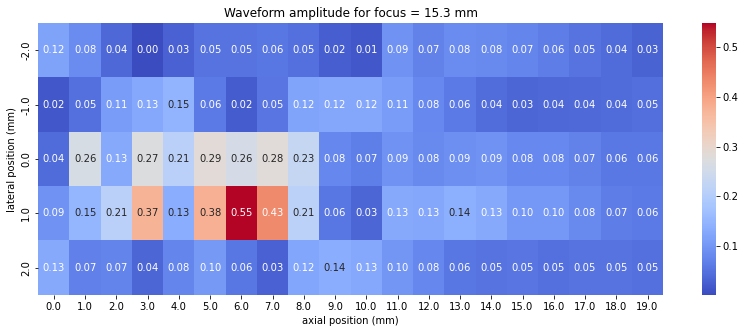

In [112]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
sns.heatmap(amplitude_grid, xticklabels=ax_pos, yticklabels=lat_pos, ax=ax, annot=True, fmt=".2f", cmap='coolwarm')
ax.set_xlabel('axial position (mm)')
ax.set_ylabel('lateral position (mm)')
ax.set_title(f'Waveform amplitude for focus = {focus} mm')

fig.savefig(f'../figures/watertank/{fig_filename_suffix}_heatmap.png', dpi=300)